In [1]:
import numpy as np
from weighted_levenshtein import lev, osa, dam_lev
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy
from prettytable import PrettyTable

In [2]:
import nltk

In [3]:
url = './OCR MLE Document.csv'
df = pd.read_csv(url)
df = df.dropna(subset=["Actual Field Name"])
df = df.reset_index()

In [28]:
field_name = df["Field Name"]
actual_field_name = df["Actual Field Name"]
lengths = field_name.apply(lambda x: len(x))

ones = np.ones(128, dtype=np.float64)
ones2 = np.ones((128, 128), dtype=np.float64)
zeros = np.zeros(128, dtype=np.float64)
zeros2 = np.zeros((128, 128), dtype=np.float64)

def levenshteinDistance(A, B):
    N, M = len(A), len(B)
    dp = [[tuple((0, [0, 0, 0])) for i in range(M + 1)] for j in range(N + 1)]
    insertion = 0
    deletion = 0 
    replacement = 0
    for j in range(M + 1):
        dp[0][j] = tuple((j, [j, 0, 0]))
    for i in range(N + 1):
        dp[i][0] = tuple((i, [0, i, 0]))
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            if A[i - 1] == B[j - 1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                inse, icounts = dp[i-1][j]
                dele, dcounts = dp[i][j-1]
                repl, rcounts = dp[i-1][j-1]
                counts = [0, 0, 0]
                if inse == min(inse, dele, repl):
                    counts = icounts.copy()
                    counts[0] += 1
                elif dele == min(inse, dele, repl):
                    counts = dcounts.copy()
                    counts[1] += 1
                else:
                    counts = rcounts.copy()
                    counts[2] += 1
                dp[i][j] = tuple((1 + min(inse, dele, repl), counts))
                
    return dp[N][M]

def edit_distance(s1, s2):
    l0, l1 = levenshteinDistance(s1, s2)
    return np.array(l1)

In [29]:
distances = np.array([(edit_distance(fn, afn)) for (fn, afn) in zip(field_name, actual_field_name)])
def loglikelihood(x, theta):
    theta1, theta2, theta3 = theta
    return np.sum(scipy.stats.poisson.logpmf(x[:, 0], theta1*lengths)
                 +scipy.stats.poisson.logpmf(x[:, 1], theta2*lengths)
                 +scipy.stats.poisson.logpmf(x[:, 2], theta3*lengths))

mles = np.exp(scipy.optimize.fmin(lambda theta: -loglikelihood(distances, np.exp(theta)), [0, 0, 0]))
print(mles*len("Total Weight"))

Optimization terminated successfully.
         Current function value: 390.830303
         Iterations: 176
         Function evaluations: 312
[0.81489784 0.63088535 0.60458837]


In [30]:
url2 = "./1b8f1057-df25-41ac-81ac-8c0b70966f80.csv"
df2 = pd.read_csv(url2)

In [31]:
field_names = df2["Field Name"]
field_names = field_names.apply(lambda x: x.lower())
distances = np.array([(edit_distance(fn, "Total Weight".lower())) for fn in field_names])

likelihoods_ins = scipy.stats.poisson.pmf(distances[:, 0], 0.81489784)
likelihoods_del = scipy.stats.poisson.pmf(distances[:, 1], 0.63088535)
likelihoods_rep = scipy.stats.poisson.pmf(distances[:, 2], 0.60458837)
    
likelihoods = likelihoods_ins * likelihoods_del * likelihoods_rep
likelihoods /= np.sum(likelihoods)
df2["fieldLikelihood"] = likelihoods

value = df2.loc[df2["fieldLikelihood"].idxmax()]["Field Value"]
likelihood = df2.loc[df2["fieldLikelihood"].idxmax()]["fieldLikelihood"]
print(value, likelihood)

1964.688Kgs 0.9999826260977809


In [32]:
value = value.replace(',', '')
value = value.replace(' ', '')
import re
z = re.search(r"\d+\.?\d*", value)
print(z.group())

1964.688


Optimization terminated successfully.
         Current function value: 388.921206
         Iterations: 434
         Function evaluations: 702


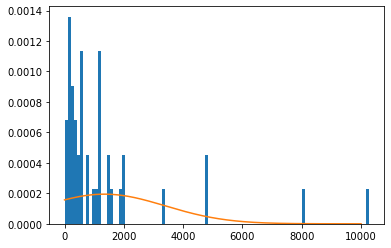

In [33]:
weights_url = "./truckWeights.csv"
df3 = pd.read_csv(weights_url)
weights = df3["Weight"]
plt.hist(df3, bins=100, density=True)

def transform(params):
    m0, m1, m2, t0, t1, t2, s0, s1 = params
    d = np.exp(s0) + np.exp(s1) + 1
    p0 = np.exp(s0) / d
    p1 = np.exp(s1) / d
    p2 = 1 / d
    return (np.exp(m0), np.exp(m1), np.exp(m2), np.exp(t0), np.exp(t1), np.exp(t2), p0, p1, p2)

def loglik(params):
    m0, m1, m2, t0, t1, t2, p0, p1, p2 = params
    a = p0*scipy.stats.norm.logpdf(weights, m0, t0)
    b = p1*scipy.stats.norm.logpdf(weights, m1, t1)
    c = p2*scipy.stats.norm.logpdf(weights, m2, t2)
    return np.sum(a+b+c)

n0, n1, n2, t0, t1, t2, s0, s1 = scipy.optimize.fmin(lambda x: -loglik(transform(x)), 
                                                                [np.log(5), np.log(10), np.log(100), np.log(100), np.log(100), np.log(100), 5, 2])

params = (transform([n0, n1, n2, t0, t1, t2, s0, s1]))

def lik(x):
    m0, m1, m2, t0, t1, t2, p0, p1, p2 = params
    a = p0*scipy.stats.norm.pdf(x, m0, t0)
    b = p1*scipy.stats.norm.pdf(x, m1, t1)
    c = p2*scipy.stats.norm.pdf(x, m2, t2)
    return (a+b+c)

x = np.linspace(0, 10000, 10000)
plt.plot(x, lik(x))